In [31]:
import praw
from psaw import PushshiftAPI
import pandas as pd
from praw.models import MoreComments
import os.path
import datetime as dt
from urllib.parse import urlparse
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from pprint import pprint
from praw.models import MoreComments

#Sentiment analyzer and threshold for polarity
nltk.download('vader_lexicon')
sia_main = SIA()
sia_comments = SIA()
sia_treshold = 0.2
results_main = []
retults_comments =[]
results_neutral_comments=[]
result_neutral=[]

#Divide all comments
AllComments_FromNegative=[]
PositiveComments_FromNegative=[]
NeutralComments_FromNegative=[]
NegativeComments_FromNegative=[]

#Log into reddit
api = PushshiftAPI()
reddit = praw.Reddit(client_id='zEC6duMW2faxMA', client_secret='F2ZETv1FiPS5DuxBGiwerboPDtXNPA', user_agent='RedditWebScrapping')
api = PushshiftAPI(reddit)
ml_subreddit = reddit.subreddit('GMAT')
limitposts=100000
comments = set()
posts = []
counts =0
print('Running code')

# Loop over the subreddit and get the info on posts 
#for post in ml_subreddit.top(limit=limitposts):
gen = api.search_submissions(subreddit='GMAT',limit=1100)
results = list(gen)
print(len(results))

for post in ml_subreddit.hot(limit=limitposts):
    counts +=1
    posts.append([post.title, post.score, post.id, post.subreddit, post.url, post.num_comments, post.selftext, dt.datetime.fromtimestamp(post.created)])
    posts = pd.DataFrame(posts,columns=['title', 'score', 'id', 'subreddit', 'url', 'num_comments', 'body', 'created'])
    url = post.url 
    # Removing links to external site or to pictures
    domain = urlparse(url).netloc
    extension = os.path.splitext(url)[1]
    #print(os.path.split(url))
    if( domain!='www.reddit.com' or extension=='.png' or extension=='.jpg'or extension=='.jpeg' or extension=='.gif' ):
        continue
    submission = reddit.submission(url=url)
    #print(post.selftext)
    pol_score_main = sia_main.polarity_scores(post.selftext)
    pol_score_main['comment'] = post.selftext
    results_main.append(pol_score_main)
    
    # Looping over the comments of the. post
    for top_level_comment in submission.comments:
        if isinstance(top_level_comment, MoreComments):
            contiunue 
        comments.add(top_level_comment.body)
        if(pol_score_main['compound']>-sia_treshold and pol_score_main['compound']>-sia_treshold):
            pol_score_comments = sia_comments.polarity_scores(top_level_comment.body)
            pol_score_comments['comment'] = top_level_comment.body
            results_neutral_comments.append(pol_score_comments)
        if(pol_score_main['compound']<-sia_treshold):
            #print("-> Comment:")
            #print(top_level_comment.body)
            pol_score_comments = sia_comments.polarity_scores(top_level_comment.body)
            pol_score_comments['comment'] = top_level_comment.body
            retults_comments.append(pol_score_comments)
            #print(pol_score_comments['compound'])
            #print(pol_score_comments['comment'])
            #if(pol_score_comments['compound']<-sia_treshold):  
            #print('-> SubCumments negative')
            #print(post.selftext)
            #print("-->I am in a comment")
            #print(top_level_comment.body)
            #print(len(top_level_comment.body))
            #print(posts)
    posts.to_csv("Comments_all.csv")

    
dfmain = pd.DataFrame.from_records(results_main)
dfmain['label'] = 0
dfmain.loc[dfmain['compound'] > sia_treshold, 'label'] = 1
dfmain.loc[dfmain['compound'] < -sia_treshold, 'label'] = -1


dfcomments = pd.DataFrame.from_records(retults_comments)
dfcomments['label'] = 0
dfcomments.loc[dfcomments['compound'] > sia_treshold, 'label'] = 1
dfcomments.loc[dfcomments['compound'] < -sia_treshold, 'label'] = -1

dfcomments["is_bad_review"] = dfcomments["compound"].apply(lambda x: 1 if x < -sia_treshold else 0)
dfmain["is_bad_review"] = dfmain["compound"].apply(lambda x: 1 if x < -sia_treshold else 0)

df_neutral_comments = pd.DataFrame.from_records(results_neutral_comments)
df_neutral_comments['label'] = 0
df_neutral_comments.loc[df_neutral_comments['compound'] > sia_treshold, 'label'] = 1
df_neutral_comments.loc[df_neutral_comments['compound'] < -sia_treshold, 'label'] = -1


# Check the negative comments
#print("\n =============================\n")
#print("\n Main Negative comments:\n")
#pprint(list(dfmain[dfmain['label'] == -1].comment)[:5], width=200)
print('Done: ', counts)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/gangelini/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Running code
200
Done:  1000


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gangelini/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gangelini/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gangelini/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Done


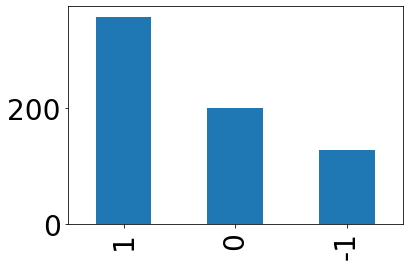

In [87]:
#Wordnet implementaiton and clearning the text 
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


def non_trivial(text):
    text = text.lower()
    text= text.replace("hi", "")
    text= text.replace("hello", "")
    text= text.replace("guys", "")
    text= text.replace("hey", "")
    text= text.replace("gmat", "")
    text= text.replace("https", "")
    text= text.replace("welcome", "")
    text= text.replace("reddit", "")
    text= text.replace("m", "")
    text= text.replace("n", "")
    text= text.replace(".jpg", "")
    text= text.replace("&#x200b", "")
    #text = [t for t in text if len(t) > 2]
    return(text)


def clean_text(text):
    # lower text
    text = text.lower()
    #remove common useless words:
    text= text.replace("congratulation", "")
    text= text.replace("congrats", "")
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    #remove words that appear twice
    text= sorted(set(text), key=lambda x:text.index(x))

# remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only two letters
    text = [t for t in text if len(t) > 2]
    # join all
    text = " ".join(text)
    return(text)

    # join all
    text = " ".join(text)
    return(text)

dfcomments["comment_clean"] = dfcomments["comment"].apply(lambda x: clean_text(x))
dfmain["comment_clean"] = dfmain["comment"].apply(lambda x: clean_text(x))
dfmain["comment_non_trival"] = dfmain["comment"].apply(lambda x: non_trivial(x))
dfcomments["comment_non_trival"] = dfcomments["comment"].apply(lambda x: non_trivial(x))
df_neutral_comments["comment_non_trival"] = df_neutral_comments["comment"].apply(lambda x: non_trivial(x))


print('Done')


dfcomments.label.value_counts().plot.bar()

In [64]:
# Applying some basic matrics to these dataset:
# First we count the number of characters and words 
from nltk.corpus import wordnet

dfmain['nb_chars'] = dfmain['comment_clean'].apply(lambda x: len(x))
dfcomments['nb_chars'] = dfmain['comment_clean'].apply(lambda x: len(x))
dfmain['nb_words'] = dfmain['comment_clean'].apply(lambda x: len(x.split(" ")))
dfcomments["nb_words"] = dfcomments["comment_clean"].apply(lambda x: len(x.split(" ")))

# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(dfcomments["comment_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = dfcomments["comment_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
dfcomments = pd.concat([dfcomments, doc2vec_df], axis=1)

# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(dfcomments["comment_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = dfcomments.index
dfcomments = pd.concat([dfcomments, tfidf_df], axis=1)
pprint(dfcomments)
print('I am done')

                                               comment  compound    neg  \
0    I can't remember where, but I read that RC pas...    0.0000  0.106   
1    Probably a combination of the two. In CR for e...    0.6597  0.000   
2    GMAT is an exam of logic and reasoning. It it ...    0.7650  0.077   
3    Why don't you just focus on the actual GMAT qu...   -0.4201  0.078   
4    That’s kinda the point. TTP prepares you conce...   -0.0516  0.094   
5    GMAT Club is notoriously harder than the rest....   -0.5486  0.114   
6    I went through all the TTP Quant lessons and t...   -0.2048  0.041   
7    There might be some questions repeated... but ...   -0.4478  0.091   
8    I will be the contrarian here and say that a 6...    0.4023  0.000   
9    Hey, I just completed my GMAT in Oct and got 7...    0.8860  0.000   
10   Have you kept an error long? There seems to be...    0.0258  0.078   
11   It sounds like you are a non-native English sp...    0.6983  0.000   
12   RC - I've observed t

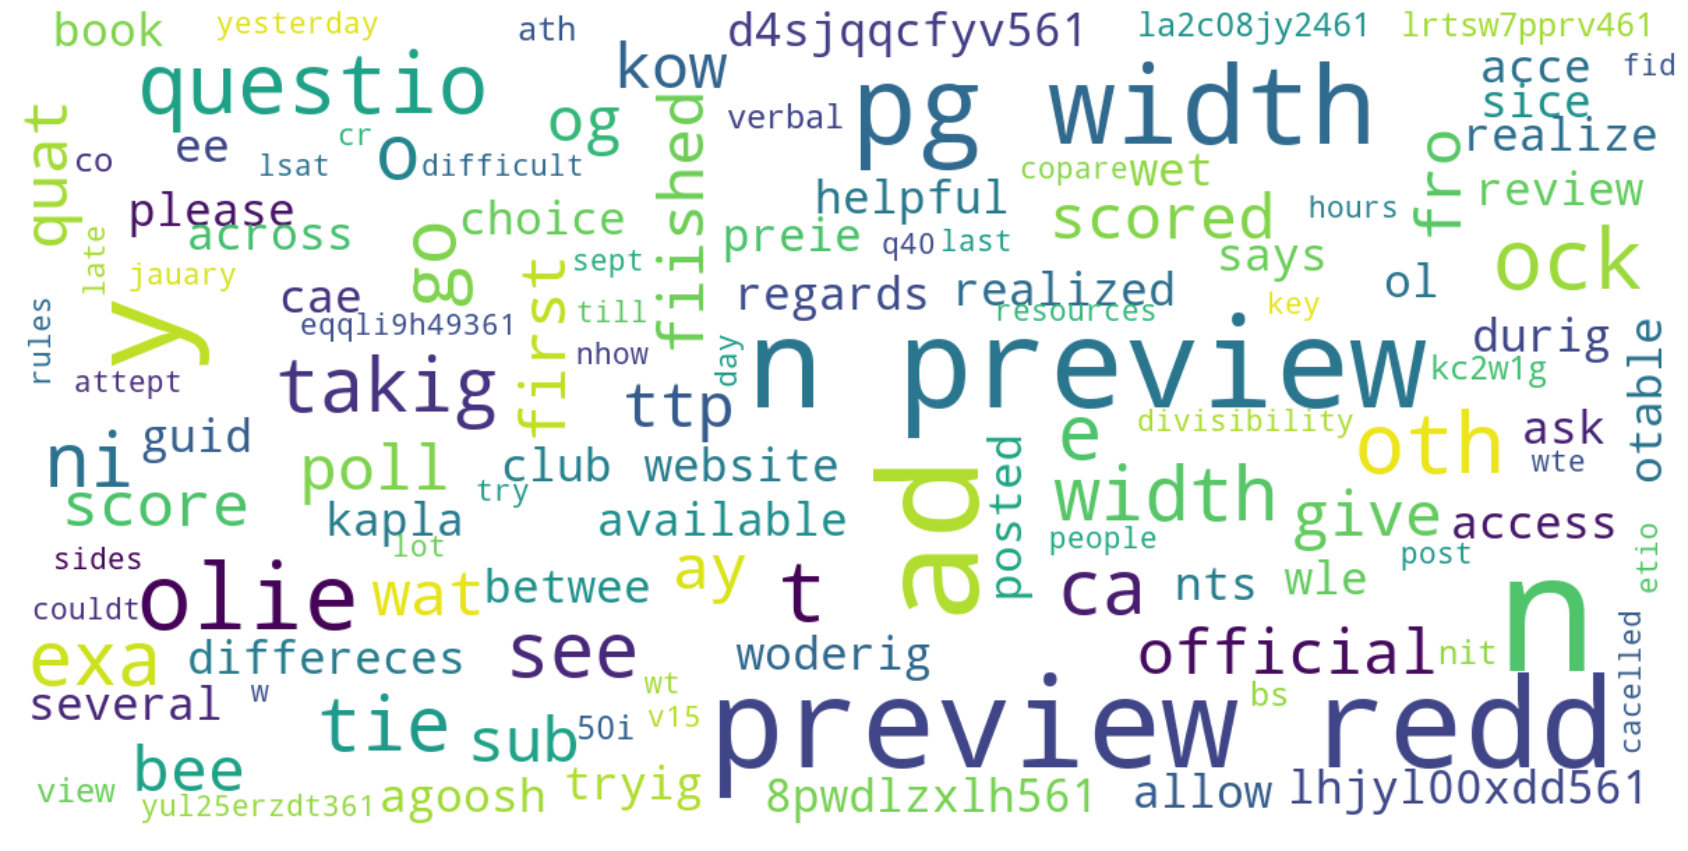

Done


In [61]:
# wordcloud function on MAIN TOPIC 

from wordcloud import WordCloud
import matplotlib.pyplot as plt


# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=40, scale=3,max_words=120, background_color="white").generate(str(dfmain.loc[dfmain['label']==0,'comment_non_trival']))
plt.figure(1,figsize=(30,30))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 120,
        max_font_size = 40, 
        scale = 3,
        random_state =42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20,20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 25)
        fig.subplots_adjust(top = 2.2)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
#show_wordcloud(dfmain.loc[dfmain['label']==0,'comment_non_trival'])
print('Done')


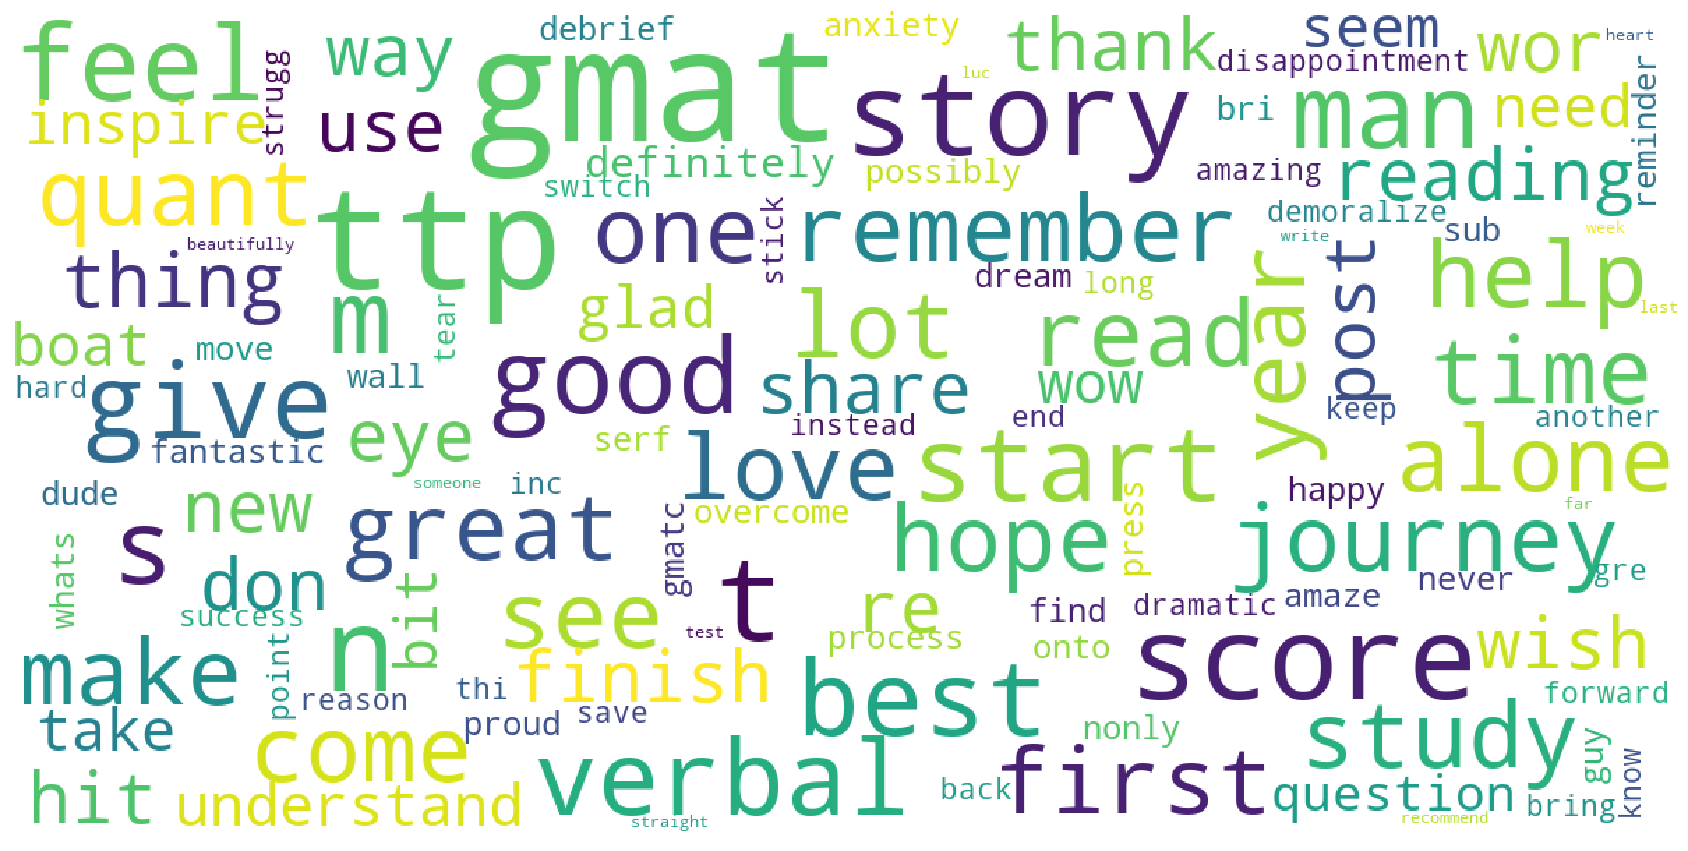

Done


In [15]:
#On Negative Comments 
# print wordcloud
show_wordcloud(dfcomments["comment_clean"])
print('Done')


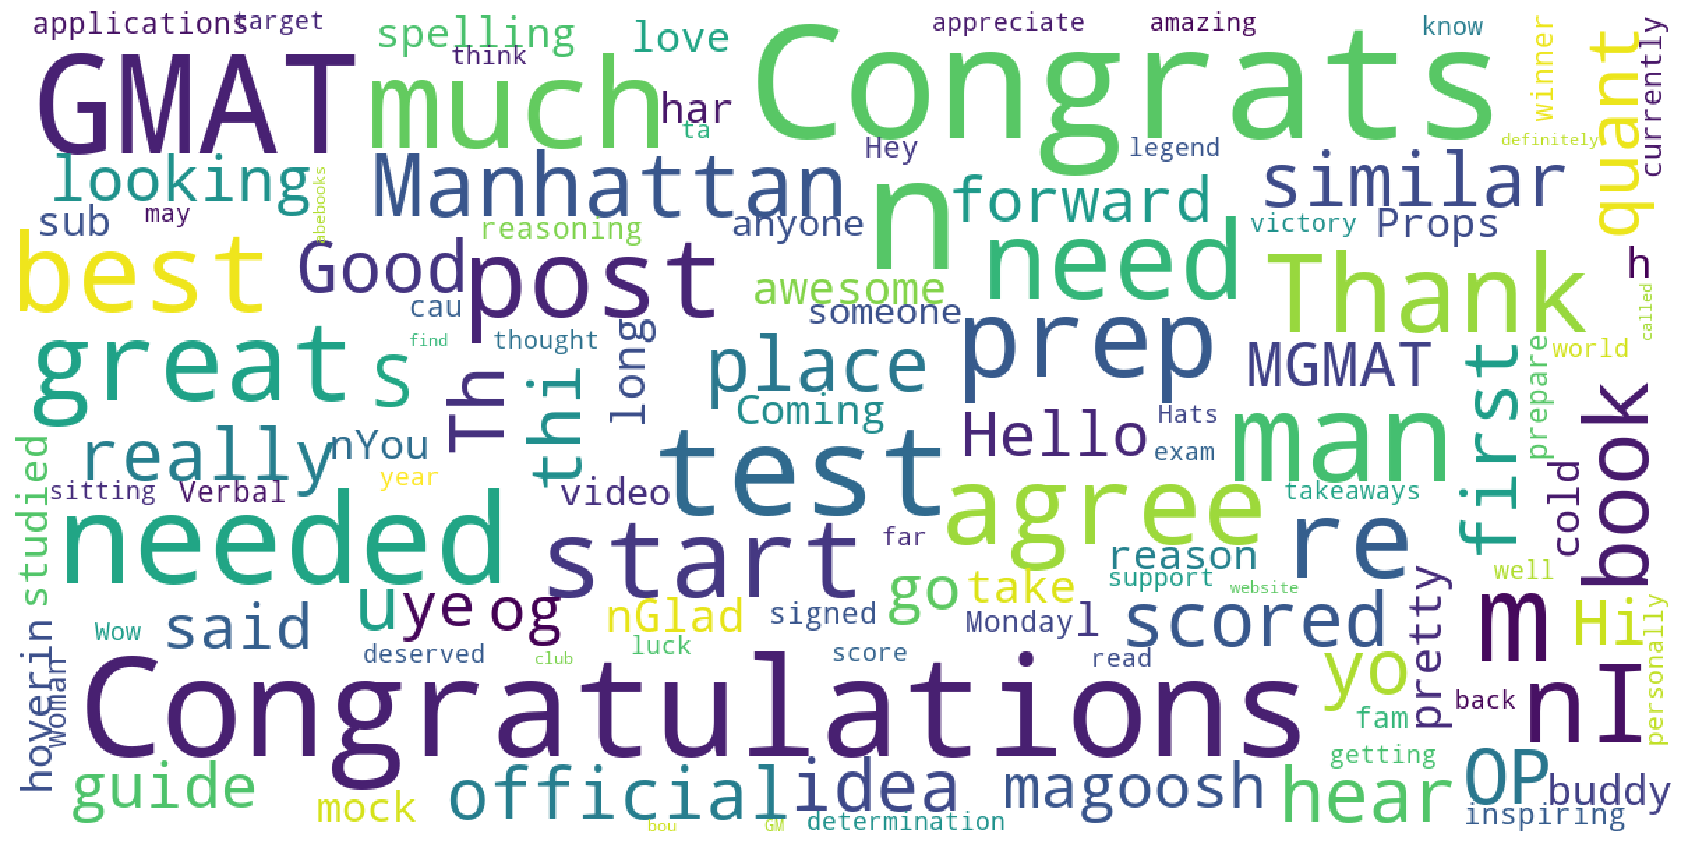

Done


In [16]:

# print wordcloud
show_wordcloud(df_neutral_comments["comment"])
print('Done')


In [79]:
def print_comment(text):
# split the text
    words = text.split()
    for word in words :
        if(word=="calling"):
            print(text)

dfcomments["comment"].apply(lambda x: print_comment(x))

Try calling the helpline and/or schedule an online exam ASAP.


0      None
1      None
2      None
3      None
4      None
5      None
6      None
7      None
8      None
9      None
10     None
11     None
12     None
13     None
14     None
15     None
16     None
17     None
18     None
19     None
20     None
21     None
22     None
23     None
24     None
25     None
26     None
27     None
28     None
29     None
       ... 
656    None
657    None
658    None
659    None
660    None
661    None
662    None
663    None
664    None
665    None
666    None
667    None
668    None
669    None
670    None
671    None
672    None
673    None
674    None
675    None
676    None
677    None
678    None
679    None
680    None
681    None
682    None
683    None
684    None
685    None
Name: comment, Length: 686, dtype: object

In [ ]:
# Random Forest : 

                     Importance       Std
word_mock              0.034698  0.033096
doc2vec_vector_1       0.028562  0.025529
nb_chars               0.025327  0.019175
nb_words               0.025308  0.023381
doc2vec_vector_4       0.024049  0.022313
doc2vec_vector_3       0.019710  0.017387
doc2vec_vector_0       0.018024  0.016591
word_get               0.017857  0.020334
doc2vec_vector_2       0.017569  0.017514
word_wrong             0.016816  0.017298
word_experience        0.015686  0.019930
word_worry             0.013804  0.020322
word_difficulty        0.012403  0.019499
word_online            0.011962  0.015007
word_specific          0.011269  0.016028
word_people            0.011190  0.018218
word_problem           0.010658  0.016657
word_difficult         0.010267  0.017248
word_weak              0.009721  0.018328
word_real              0.009571  0.017899
word_give              0.009409  0.013473
word_test              0.009375  0.014367
word_ve                0.009329  0

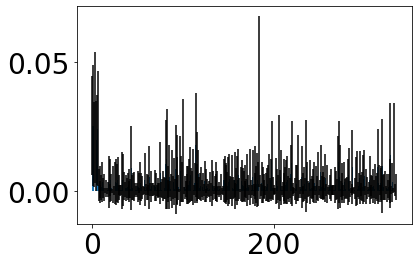

In [85]:
import numpy as np
import matplotlib.pyplot as plt
# Use a Random Forest to check thge world that are more relavent 
# feature selection
label = "is_bad_review"
ignore_cols = [label,"comment", "comment_clean",'compound','label','neg','pos','neu']
features = [c for c in dfcomments.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dfcomments[features], dfcomments[label], test_size = 0.20, random_state = 42)
#pprint(X_train)
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in rf.estimators_], axis=0)


#pprint(importance.sort_values("Importance", ascending = False).head(400))
print(importance.sort_values("Importance", ascending = False).to_string())

x = range(importance.shape[0])
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.bar(x, y, yerr=yerr, align="center")

plt.show()

#feature_importances_df = pd.DataFrame({"importance": rf.feature_importances_})
#pprint(feature_importances_df.sort_values("importance", ascending = False))
#feature_df = pd.DataFrame({"features": rf.features})
#pprint(feature_df)
# show feature importance
#feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
#feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
#feature_importances_df.head(20)

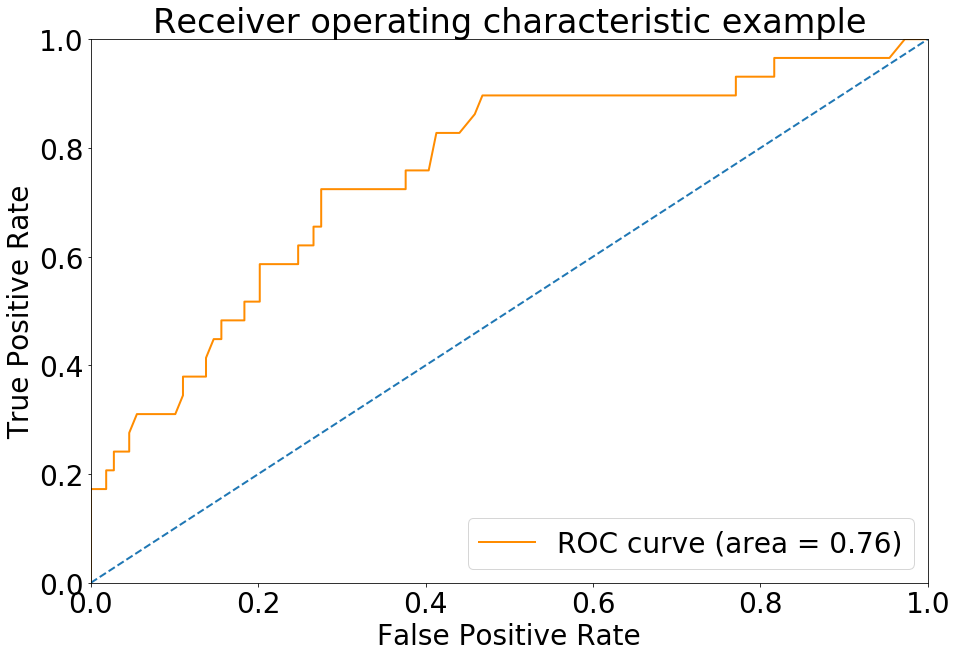

In [86]:
# ROC curve

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

y_pred = [x[1] for x in rf.predict_proba(X_test)]
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label = 1)

roc_auc = auc(fpr, tpr)

plt.figure(1, figsize = (15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.rc('font', size=28)
plt.show()

In [ ]:
# PR curve

from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.utils.fixes import signature

average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize = (15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

In [ ]:
#vader sentiment analysis on the comments of posts

sia = SIA()
results = []

# Get the things out of the body
for line in posts.body:
    print(posts.body)
for line in comments:
    pol_score = sia.polarity_scores(line)
    pol_score['comment'] = line
    results.append(pol_score)
   # pprint(results[:7], width=100)
df1 = pd.DataFrame.from_records(results)
df1['label'] = 0
df1.loc[df1['compound'] > 0.2, 'label'] = 1
df1.loc[df1['compound'] < -0.2, 'label'] = -1
df1.head()
df2 = df1[['comment', 'label']]
df2.to_csv('reddit_comment_labels.csv', mode='a', encoding='utf-8', index=False)
#print("Positive comments:\n")
#pprint(list(df1[df1['label'] == 1].comment)[:5], width=200)
print("\nNegative comments:\n")
pprint(list(df1[df1['label'] == -1].comment)[:5], width=200)


In [ ]:
# we can tell positive comments are not that positive in reality
print(df1.label.value_counts())
print(df1.label.value_counts(normalize=True) * 100)
df1.label.value_counts().plot.bar()

In [ ]:
#Wordnet implementaiton and clearning text function 
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

df1["comment_clean"] = df1["comment"].apply(lambda x: clean_text(x))
pprint(list(df1.comment_clean)[:5], width=200)


sia = SIA()
resultsclean = []
for line in df1.comment_clean:
    pol_score = sia.polarity_scores(line)
    pol_score['comment_clean'] = line
    resultsclean.append(pol_score)
   # pprint(resultsclean[:7], width=100)
df1_clean = pd.DataFrame.from_records(resultsclean)
df1_clean['label'] = 0
df1_clean.loc[df1['compound'] > 0.2, 'label'] = 1
df1_clean.loc[df1['compound'] < -0.2, 'label'] = -1
df1_clean.head()
df2_clean = df1[['comment', 'label']]
print("\nNegative comments:\n")
pprint(list(df1_clean[df1_clean['label'] == -1].comment_clean)[:5], width=200)
df2_clean.label.value_counts().plot.bar()